# 图像分类

在此项目中，你将对 [CIFAR-10 数据集](https://www.cs.toronto.edu/~kriz/cifar.html) 中的图片进行分类。该数据集包含飞机、猫狗和其他物体。你需要预处理这些图片，然后用所有样本训练一个卷积神经网络。图片需要标准化（normalized），标签需要采用 one-hot 编码。你需要应用所学的知识构建卷积的、最大池化（max pooling）、丢弃（dropout）和完全连接（fully connected）的层。最后，你需要在样本图片上看到神经网络的预测结果。


## 获取数据

请运行以下单元，以下载 [CIFAR-10 数据集（Python版）](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz)。


In [3]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import problem_unittests as tests
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

# Use Floyd's cifar-10 dataset if present
floyd_cifar10_location = '/input/cifar-10/python.tar.gz'
if isfile(floyd_cifar10_location):
    tar_gz_path = floyd_cifar10_location
else:
    tar_gz_path = 'cifar-10-python.tar.gz'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(tar_gz_path):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            tar_gz_path,
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open(tar_gz_path) as tar:
        tar.extractall()
        tar.close()


tests.test_folder_path(cifar10_dataset_folder_path)

All files found!


## 探索数据

该数据集分成了几部分／批次（batches），以免你的机器在计算时内存不足。CIFAR-10 数据集包含 5 个部分，名称分别为 `data_batch_1`、`data_batch_2`，以此类推。每个部分都包含以下某个类别的标签和图片：

* 飞机
* 汽车
* 鸟类
* 猫
* 鹿
* 狗
* 青蛙
* 马
* 船只
* 卡车

了解数据集也是对数据进行预测的必经步骤。你可以通过更改 `batch_id` 和 `sample_id` 探索下面的代码单元。`batch_id` 是数据集一个部分的 ID（1 到 5）。`sample_id` 是该部分中图片和标签对（label pair）的 ID。

问问你自己：“可能的标签有哪些？”、“图片数据的值范围是多少？”、“标签是按顺序排列，还是随机排列的？”。思考类似的问题，有助于你预处理数据，并使预测结果更准确。



Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 5:
Image - Min Value: 0 Max Value: 252
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile


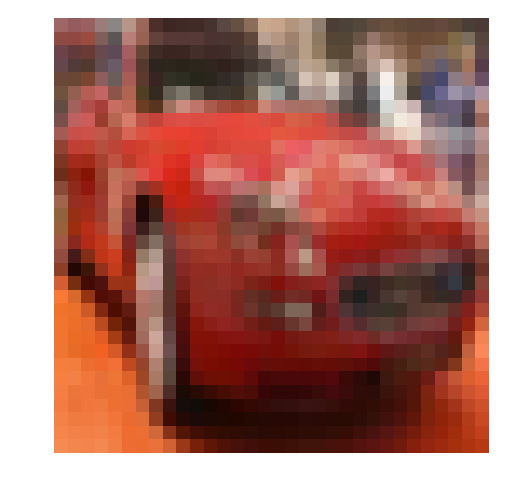

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

# Explore the dataset
batch_id = 1
sample_id = 5
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## 实现预处理函数

### 标准化

在下面的单元中，实现 `normalize` 函数，传入图片数据 `x`，并返回标准化 Numpy 数组。值应该在 0 到 1 的范围内（含 0 和 1）。返回对象应该和 `x` 的形状一样。


In [5]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    # TODO: Implement Function
    return x / 255


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_normalize(normalize)

Tests Passed


### One-hot 编码

和之前的代码单元一样，你将为预处理实现一个函数。这次，你将实现 `one_hot_encode` 函数。输入，也就是 `x`，是一个标签列表。实现该函数，以返回为 one_hot 编码的 Numpy 数组的标签列表。标签的可能值为 0 到 9。每次调用 `one_hot_encode` 时，对于每个值，one_hot 编码函数应该返回相同的编码。确保将编码映射保存到该函数外面。

提示：不要重复发明轮子。


In [6]:
def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    height = len(x)
    width = 10
    res = np.zeros((height, width))
    res[np.arange(height), x] = 1
    return res


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_one_hot_encode(one_hot_encode)

Tests Passed


### 随机化数据

之前探索数据时，你已经了解到，样本的顺序是随机的。再随机化一次也不会有什么关系，但是对于这个数据集没有必要。


## 预处理所有数据并保存

运行下方的代码单元，将预处理所有 CIFAR-10 数据，并保存到文件中。下面的代码还使用了 10% 的训练数据，用来验证。


In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

# 检查点

这是你的第一个检查点。如果你什么时候决定再回到该记事本，或需要重新启动该记事本，你可以从这里开始。预处理的数据已保存到本地。


In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle
import problem_unittests as tests
import helper

# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## 构建网络

对于该神经网络，你需要将每层都构建为一个函数。你看到的大部分代码都位于函数外面。要更全面地测试你的代码，我们需要你将每层放入一个函数中。这样使我们能够提供更好的反馈，并使用我们的统一测试检测简单的错误，然后再提交项目。

>**注意**：如果你觉得每周很难抽出足够的时间学习这门课程，我们为此项目提供了一个小捷径。对于接下来的几个问题，你可以使用 [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) 或 [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) 程序包中的类来构建每个层级，但是“卷积和最大池化层级”部分的层级除外。TF Layers 和 Keras 及 TFLearn 层级类似，因此很容易学会。

>但是，如果你想充分利用这门课程，请尝试自己解决所有问题，不使用 TF Layers 程序包中的任何类。你依然可以使用其他程序包中的类，这些类和你在 TF Layers 中的类名称是一样的！例如，你可以使用 TF Neural Network 版本的 `conv2d` 类 [tf.nn.conv2d](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d)，而不是 TF Layers 版本的 `conv2d` 类 [tf.layers.conv2d](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d)。

我们开始吧！


### 输入

神经网络需要读取图片数据、one-hot 编码标签和丢弃保留概率（dropout keep probability）。请实现以下函数：

* 实现 `neural_net_image_input`
 * 返回 [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * 使用 `image_shape` 设置形状，部分大小设为 `None`
 * 使用 [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder) 中的 TensorFlow `name` 参数对 TensorFlow 占位符 "x" 命名
* 实现 `neural_net_label_input`
 * 返回 [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * 使用 `n_classes` 设置形状，部分大小设为 `None`
 * 使用 [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder) 中的 TensorFlow `name` 参数对 TensorFlow 占位符 "y" 命名
* 实现 `neural_net_keep_prob_input`
 * 返回 [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)，用于丢弃保留概率
 * 使用 [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder) 中的 TensorFlow `name` 参数对 TensorFlow 占位符 "keep_prob" 命名

这些名称将在项目结束时，用于加载保存的模型。

注意：TensorFlow 中的 `None` 表示形状可以是动态大小。

In [9]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a batch of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    # TODO: Implement Function
    return tf.placeholder(tf.float32,shape=(None,*image_shape),name="x")


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    # TODO: Implement Function
    return tf.placeholder(tf.int32,shape=(None,n_classes),name="y")


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    # TODO: Implement Function
    return tf.placeholder(tf.float32,name="keep_prob")


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tf.reset_default_graph()
tests.test_nn_image_inputs(neural_net_image_input)
tests.test_nn_label_inputs(neural_net_label_input)
tests.test_nn_keep_prob_inputs(neural_net_keep_prob_input)

Image Input Tests Passed.
Label Input Tests Passed.
Keep Prob Tests Passed.


### 卷积和最大池化层

卷积层级适合处理图片。对于此代码单元，你应该实现函数 `conv2d_maxpool` 以便应用卷积然后进行最大池化：

* 使用 `conv_ksize`、`conv_num_outputs` 和 `x_tensor` 的形状创建权重（weight）和偏置（bias）。
* 使用权重和 `conv_strides` 对 `x_tensor` 应用卷积。
 * 建议使用我们建议的间距（padding），当然也可以使用任何其他间距。
* 添加偏置
* 向卷积中添加非线性激活（nonlinear activation）
* 使用 `pool_ksize` 和 `pool_strides` 应用最大池化
 * 建议使用我们建议的间距（padding），当然也可以使用任何其他间距。

**注意**：对于**此层**，**请勿使用** [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) 或 [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers)，但是仍然可以使用 TensorFlow 的 [Neural Network](https://www.tensorflow.org/api_docs/python/tf/nn) 包。对于所有**其他层**，你依然可以使用快捷方法。


In [10]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    conv = tf.nn.conv2d(
        x_tensor,
        tf.Variable(tf.truncated_normal((*conv_ksize,int(x_tensor.shape[-1]),conv_num_outputs))),
        #tf.placeholder(tf.float32, shape=(*conv_ksize,x_tensor.shape[-1],conv_num_outputs)),
        [1,*conv_strides,1],
        'VALID'
    )
    pool = tf.nn.max_pool(conv,[1,*pool_ksize,1],[1,*pool_strides,1],'VALID','NHWC')
    return pool 


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_con_pool(conv2d_maxpool)

Tests Passed


### 扁平化层

实现 `flatten` 函数，将 `x_tensor` 的维度从四维张量（4-D tensor）变成二维张量。输出应该是形状（*部分大小（Batch Size）*，*扁平化图片大小（Flattened Image Size）*）。快捷方法：对于此层，你可以使用 [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) 或 [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) 包中的类。如果你想要更大挑战，可以仅使用其他 TensorFlow 程序包。


In [11]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    # TODO: Implement Function
    return tf.contrib.layers.flatten(x_tensor)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_flatten(flatten)

Tests Passed


### 全连接层

实现 `fully_conn` 函数，以向 `x_tensor` 应用完全连接的层级，形状为（*部分大小（Batch Size）*，*num_outputs*）。快捷方法：对于此层，你可以使用 [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) 或 [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) 包中的类。如果你想要更大挑战，可以仅使用其他 TensorFlow 程序包。

In [12]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # TODO: Implement Function
    return tf.contrib.layers.fully_connected(x_tensor, num_outputs)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_fully_conn(fully_conn)

Tests Passed


### 输出层

实现 `output` 函数，向 x_tensor 应用完全连接的层级，形状为（*部分大小（Batch Size）*，*num_outputs*）。快捷方法：对于此层，你可以使用 [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) 或 [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) 包中的类。如果你想要更大挑战，可以仅使用其他 TensorFlow 程序包。

**注意**：该层级不应应用 Activation、softmax 或交叉熵（cross entropy）。

In [13]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # TODO: Implement Function
    return tf.contrib.layers.fully_connected(x_tensor, num_outputs, activation_fn=None)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_output(output)

Tests Passed


### 创建卷积模型

实现函数 `conv_net`， 创建卷积神经网络模型。该函数传入一批图片 `x`，并输出对数（logits）。使用你在上方创建的层创建此模型：

* 应用 1、2 或 3 个卷积和最大池化层（Convolution and Max Pool layers）
* 应用一个扁平层（Flatten Layer）
* 应用 1、2 或 3 个完全连接层（Fully Connected Layers）
* 应用一个输出层（Output Layer）
* 返回输出
* 使用 `keep_prob` 向模型中的一个或多个层应用 [TensorFlow 的 Dropout](https://www.tensorflow.org/api_docs/python/tf/nn/dropout)

In [14]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    # TODO: Apply 1, 2, or 3 Convolution and Max Pool layers
    #    Play around with different number of outputs, kernel size and stride
    # Function Definition from Above:
    #    conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
    x_tensor = tf.cast(normalize(x), tf.float32)
    layer1 = conv2d_maxpool(x_tensor, 6, (5,5), (1,1), (2,2), (2,2))
    layer2 = conv2d_maxpool(layer1, 16, (5,5), (1,1), (2,2), (2,2))

    # TODO: Apply a Flatten Layer
    # Function Definition from Above:
    #   flatten(x_tensor)
    flat_x = flatten(layer2)

    # TODO: Apply 1, 2, or 3 Fully Connected Layers
    #    Play around with different number of outputs
    # Function Definition from Above:
    #   fully_conn(x_tensor, num_outputs)
    fc3 = fully_conn(flat_x, 120)
    fc4 = fully_conn(fc3, 84)
    
    # TODO: Apply an Output Layer
    #    Set this to the number of classes
    # Function Definition from Above:
    #   output(x_tensor, num_outputs)
    
    # TODO: return output
    return output(fc4, 10)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

tests.test_conv_net(conv_net)

Neural Network Built!


## 训练神经网络

### 单次优化

实现函数 `train_neural_network` 以进行单次优化（single optimization）。该优化应该使用 `optimizer` 优化 `session`，其中 `feed_dict` 具有以下参数：

* `x` 表示图片输入
* `y` 表示标签
* `keep_prob` 表示丢弃的保留率

每个部分都会调用该函数，所以 `tf.global_variables_initializer()` 已经被调用。

注意：不需要返回任何内容。该函数只是用来优化神经网络。


In [15]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    # TODO: Implement Function
    session.run(optimizer, feed_dict={x:feature_batch, y:label_batch, keep_prob:keep_probability})


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_train_nn(train_neural_network)

Tests Passed


### 显示数据

实现函数 `print_stats` 以输出损失和验证准确率。使用全局变量 `valid_features` 和 `valid_labels` 计算验证准确率。使用保留率 `1.0` 计算损失和验证准确率（loss and validation accuracy）。


In [16]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    # TODO: Implement Function
    valid_cost = session.run(cost, feed_dict={x:feature_batch,y:label_batch,keep_prob:1.0})
    valid_accuacy = session.run(accuracy, feed_dict={x:valid_features,y:valid_labels,keep_prob:1.0})
    print("cost is %s.  accuacy is %s" % (valid_cost,valid_accuacy))

### 超参数

调试以下超参数：
* 设置 `epochs` 表示神经网络停止学习或开始过拟合的迭代次数
* 设置 `batch_size`，表示机器内存允许的部分最大体积。大部分人设为以下常见内存大小：

 * 64
 * 128
 * 256
 * ...
* 设置 `keep_probability` 表示使用丢弃时保留节点的概率

In [18]:
# TODO: Tune Parameters
epochs = 100
batch_size = 256
keep_probability = 0.5

### 在单个 CIFAR-10 部分上训练

我们先用单个部分，而不是用所有的 CIFAR-10 批次训练神经网络。这样可以节省时间，并对模型进行迭代，以提高准确率。最终验证准确率达到 50% 或以上之后，在下一部分对所有数据运行模型。


In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1:  cost is 2.14418.  accuacy is 0.276
Epoch  2, CIFAR-10 Batch 1:  cost is 2.12796.  accuacy is 0.3072
Epoch  3, CIFAR-10 Batch 1:  cost is 2.059.  accuacy is 0.3418
Epoch  4, CIFAR-10 Batch 1:  cost is 1.96801.  accuacy is 0.3712
Epoch  5, CIFAR-10 Batch 1:  cost is 1.8749.  accuacy is 0.3878
Epoch  6, CIFAR-10 Batch 1:  cost is 1.78006.  accuacy is 0.406
Epoch  7, CIFAR-10 Batch 1:  cost is 1.69359.  accuacy is 0.4174
Epoch  8, CIFAR-10 Batch 1:  cost is 1.62066.  accuacy is 0.4272
Epoch  9, CIFAR-10 Batch 1:  cost is 1.53888.  accuacy is 0.4374
Epoch 10, CIFAR-10 Batch 1:  cost is 1.46694.  accuacy is 0.4476
Epoch 11, CIFAR-10 Batch 1:  cost is 1.39512.  accuacy is 0.4536
Epoch 12, CIFAR-10 Batch 1:  cost is 1.32946.  accuacy is 0.46
Epoch 13, CIFAR-10 Batch 1:  cost is 1.27505.  accuacy is 0.466
Epoch 14, CIFAR-10 Batch 1:  cost is 1.208.  accuacy is 0.4724
Epoch 15, CIFAR-10 Batch 1:  cost is 1.15259.  accuacy is

### 完全训练模型

现在，单个 CIFAR-10 部分的准确率已经不错了，试试所有五个部分吧。

In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  cost is 2.22777.  accuacy is 0.2606
Epoch  1, CIFAR-10 Batch 2:  cost is 1.97027.  accuacy is 0.3034
Epoch  1, CIFAR-10 Batch 3:  cost is 1.70548.  accuacy is 0.318
Epoch  1, CIFAR-10 Batch 4:  cost is 1.77951.  accuacy is 0.3392
Epoch  1, CIFAR-10 Batch 5:  cost is 1.77696.  accuacy is 0.3588
Epoch  2, CIFAR-10 Batch 1:  cost is 2.02273.  accuacy is 0.3618
Epoch  2, CIFAR-10 Batch 2:  cost is 1.80875.  accuacy is 0.38
Epoch  2, CIFAR-10 Batch 3:  cost is 1.44635.  accuacy is 0.3804
Epoch  2, CIFAR-10 Batch 4:  cost is 1.60556.  accuacy is 0.3928
Epoch  2, CIFAR-10 Batch 5:  cost is 1.68417.  accuacy is 0.4176
Epoch  3, CIFAR-10 Batch 1:  cost is 1.88355.  accuacy is 0.4206
Epoch  3, CIFAR-10 Batch 2:  cost is 1.71045.  accuacy is 0.4266
Epoch  3, CIFAR-10 Batch 3:  cost is 1.28302.  accuacy is 0.427
Epoch  3, CIFAR-10 Batch 4:  cost is 1.47686.  accuacy is 0.4346
Epoch  3, CIFAR-10 Batch 5:  cost is 1.62378.  accuacy is 0.4478
Epoch  4, CIFAR-1

Epoch 26, CIFAR-10 Batch 1:  cost is 0.526085.  accuacy is 0.5822
Epoch 26, CIFAR-10 Batch 2:  cost is 0.477947.  accuacy is 0.5796
Epoch 26, CIFAR-10 Batch 3:  cost is 0.348558.  accuacy is 0.5794
Epoch 26, CIFAR-10 Batch 4:  cost is 0.428346.  accuacy is 0.588
Epoch 26, CIFAR-10 Batch 5:  cost is 0.405901.  accuacy is 0.5798
Epoch 27, CIFAR-10 Batch 1:  cost is 0.495195.  accuacy is 0.5854
Epoch 27, CIFAR-10 Batch 2:  cost is 0.451753.  accuacy is 0.582
Epoch 27, CIFAR-10 Batch 3:  cost is 0.33402.  accuacy is 0.5798
Epoch 27, CIFAR-10 Batch 4:  cost is 0.410094.  accuacy is 0.5848
Epoch 27, CIFAR-10 Batch 5:  cost is 0.38134.  accuacy is 0.5798
Epoch 28, CIFAR-10 Batch 1:  cost is 0.472765.  accuacy is 0.5864
Epoch 28, CIFAR-10 Batch 2:  cost is 0.431867.  accuacy is 0.5822
Epoch 28, CIFAR-10 Batch 3:  cost is 0.317447.  accuacy is 0.5824
Epoch 28, CIFAR-10 Batch 4:  cost is 0.393909.  accuacy is 0.5872
Epoch 28, CIFAR-10 Batch 5:  cost is 0.360224.  accuacy is 0.5812
Epoch 29, CIFA

Epoch 51, CIFAR-10 Batch 1:  cost is 0.192845.  accuacy is 0.5898
Epoch 51, CIFAR-10 Batch 2:  cost is 0.174878.  accuacy is 0.5828
Epoch 51, CIFAR-10 Batch 3:  cost is 0.13081.  accuacy is 0.5954
Epoch 51, CIFAR-10 Batch 4:  cost is 0.181858.  accuacy is 0.5866
Epoch 51, CIFAR-10 Batch 5:  cost is 0.14596.  accuacy is 0.5886
Epoch 52, CIFAR-10 Batch 1:  cost is 0.187826.  accuacy is 0.5894
Epoch 52, CIFAR-10 Batch 2:  cost is 0.170545.  accuacy is 0.5798
Epoch 52, CIFAR-10 Batch 3:  cost is 0.126023.  accuacy is 0.5962
Epoch 52, CIFAR-10 Batch 4:  cost is 0.176363.  accuacy is 0.5858
Epoch 52, CIFAR-10 Batch 5:  cost is 0.140007.  accuacy is 0.5896
Epoch 53, CIFAR-10 Batch 1:  cost is 0.186955.  accuacy is 0.5894
Epoch 53, CIFAR-10 Batch 2:  cost is 0.167227.  accuacy is 0.5762
Epoch 53, CIFAR-10 Batch 3:  cost is 0.120256.  accuacy is 0.5964
Epoch 53, CIFAR-10 Batch 4:  cost is 0.173025.  accuacy is 0.5846
Epoch 53, CIFAR-10 Batch 5:  cost is 0.135226.  accuacy is 0.5872
Epoch 54, CI

Epoch 75, CIFAR-10 Batch 5:  cost is 0.096145.  accuacy is 0.5666
Epoch 76, CIFAR-10 Batch 1:  cost is 0.103814.  accuacy is 0.5788
Epoch 76, CIFAR-10 Batch 2:  cost is 0.0824078.  accuacy is 0.5792
Epoch 76, CIFAR-10 Batch 3:  cost is 0.0591658.  accuacy is 0.5844
Epoch 76, CIFAR-10 Batch 4:  cost is 0.105883.  accuacy is 0.5784
Epoch 76, CIFAR-10 Batch 5:  cost is 0.0945357.  accuacy is 0.5676
Epoch 77, CIFAR-10 Batch 1:  cost is 0.100357.  accuacy is 0.5798
Epoch 77, CIFAR-10 Batch 2:  cost is 0.0811521.  accuacy is 0.5796
Epoch 77, CIFAR-10 Batch 3:  cost is 0.0568601.  accuacy is 0.5832
Epoch 77, CIFAR-10 Batch 4:  cost is 0.103763.  accuacy is 0.577
Epoch 77, CIFAR-10 Batch 5:  cost is 0.0933609.  accuacy is 0.5664
Epoch 78, CIFAR-10 Batch 1:  cost is 0.0948943.  accuacy is 0.578
Epoch 78, CIFAR-10 Batch 2:  cost is 0.0784716.  accuacy is 0.5804
Epoch 78, CIFAR-10 Batch 3:  cost is 0.0555352.  accuacy is 0.5828
Epoch 78, CIFAR-10 Batch 4:  cost is 0.101221.  accuacy is 0.576
Epoc

Epoch 100, CIFAR-10 Batch 3:  cost is 0.0391703.  accuacy is 0.583
Epoch 100, CIFAR-10 Batch 4:  cost is 0.0651195.  accuacy is 0.5742
Epoch 100, CIFAR-10 Batch 5:  cost is 0.0479788.  accuacy is 0.5698


# 检查点

模型已保存到本地。

## 测试模型

利用测试数据集测试你的模型。这将是最终的准确率。你的准确率应该高于 50%。如果没达到，请继续调整模型结构和参数。

INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.56103515625



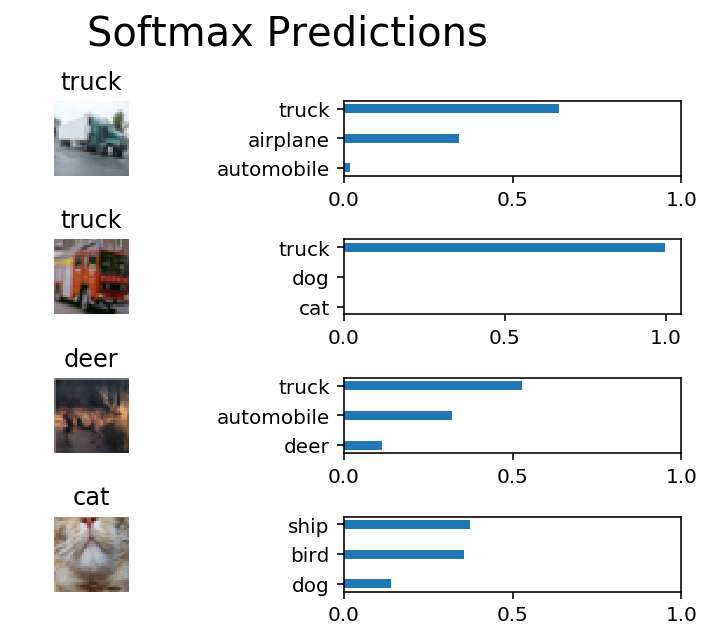

In [21]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for test_feature_batch, test_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()

## 为何准确率只有50-80%？

你可能想问，为何准确率不能更高了？首先，对于简单的 CNN 网络来说，50% 已经不低了。纯粹猜测的准确率为10%。但是，你可能注意到有人的准确率[远远超过 80%](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130)。这是因为我们还没有介绍所有的神经网络知识。我们还需要掌握一些其他技巧。

## 提交项目

提交项目时，确保先运行所有单元，然后再保存记事本。将 notebook 文件另存为“dlnd_image_classification.ipynb”，再在目录 "File" -> "Download as" 另存为 HTML 格式。请在提交的项目中包含 “helper.py” 和 “problem_unittests.py” 文件。
